# Cassandra FIX Datamodels

## Notes


### Links

- [Cassandra Driver](https://datastax.github.io/python-driver/getting_started.html)
- [Ebay data modeling](https://www.ebayinc.com/stories/blogs/tech/cassandra-data-modeling-best-practices-part-1/)
- [Time series modeling at massive scale](http://thelastpickle.com/blog/2017/08/02/time-series-data-modeling-massive-scale.html)
- [Advanced-time-series-with-cassandra](https://www.datastax.com/dev/blog/advanced-time-series-with-cassandra)
- ⭐️  [Getting-started-time-series-data-modeling](https://academy.datastax.com/resources/getting-started-time-series-data-modeling)
- [Partitioning and replication](https://www.datastax.com/resources/tutorials/partitioning-and-replication)

In [1]:
%matplotlib inline
from cassandra.cluster import Cluster
import pandas as pd

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cluster = Cluster()
s = cluster.connect()

Pandas intergration

In [3]:
def pandas_factory(colnames, rows):
    return pd.DataFrame(rows, columns=colnames)

s.row_factory = pandas_factory
s.default_fetch_size = None

## Create keyspace

In [58]:
KEY_SPACE_NAME = "fix_db"

In [59]:
s.execute("DROP KEYSPACE " + KEY_SPACE_NAME )

In [60]:
KEY_SPACE = "CREATE KEYSPACE IF NOT EXISTS " + KEY_SPACE_NAME + " WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };"

s.execute(KEY_SPACE)
s.set_keyspace(KEY_SPACE_NAME)

## Data models

### Bucketing
Multiple transactions happen per time unit (week, day, hour, minute) per *stock symbol* per *Source id*. The right time granularity must be chosen to make sure the maximum ammount of columns (2.000.000.000) is not exeeded. This is done through "bucketing". For now the daily time granularity sufficies. 

<center>**Bucketing per time granularity**</center>


| Time     | Record per second |
|----------|-------------------|
| Minute   | 33.333.333        |
| Hourly   | 555.555           |
| Daily    | 23.148            |
| Weekly   | 3.306             |
| Monthly  | 826               |
| Quaterly | 275               |
| Yearly   | 68                |



### FIX by day
Storing _all_ data by day timegranulairty
Primary key:
- **Source ID**, the id of the source (i.e. *ICE*)
- **Symbol**, the stock symbol (i.e. *AAPL*, *GOOGL*)
- **Day**, the day the transaction happend (*YYYYMMDD*)
- **Unique timestamp**, this is a generated value to prevent bid timestamp collisions

Columns:
- FIX, Map containing all FIX values by token name

In [53]:
FIX_BY_DAY_TABLE = """
CREATE TABLE IF NOT EXISTS fix_by_day (
src_id text,
symbol text,
day timestamp,
uts timeuuid,
fix map<text,text>,
primary key((src_id, symbol, day), uts)
)
"""

s.execute(FIX_BY_DAY_TABLE)

In [55]:
rslt = s.execute("SELECT * FROM fix_by_day", timeout=None)
rslt._current_rows.tail()

,src_id,symbol,day,uts,fix
151135,788,P:1052P,2018-04-10,98fe95f8-529b-11e8-9fb9-8bb2d55d4160,"[ASK.COUNT, ASK.PRICE, ASK.SIZE, DELAY_MINS, E..."
151136,788,P:5430C,2018-04-10,94c8183a-529b-11e8-9fb9-8bb2d55d4160,"[BID.COUNT, BID.PRICE, BID.SIZE, DELAY_MINS, E..."
151137,788,P:5430C,2018-04-10,94c83f4a-529b-11e8-9fb9-8bb2d55d4160,"[BID.COUNT, BID.PRICE, BID.SIZE, DELAY_MINS, E..."
151138,788,P:5430C,2018-04-10,996c24d0-529b-11e8-9fb9-8bb2d55d4160,"[BID.COUNT, BID.PRICE, BID.SIZE, DELAY_MINS, E..."
151139,788,P:5430C,2018-04-10,996c24da-529b-11e8-9fb9-8bb2d55d4160,"[BID.COUNT, BID.PRICE, BID.SIZE, DELAY_MINS, E..."


### Bids by day
Primary key:
- **Source id**
- **Symbol**
- **Day**
- **Unique timestamp**
- **Bid timestamp**, exact timestamp of bid

Columns:
- **Bid price**
- **Bid size**

In [145]:
BIDS_BY_DAY = """
CREATE TABLE IF NOT EXISTS bids_by_day (
src_id text,
symbol text,
day timestamp,
uts timeuuid,
bid_ts timestamp,
bid_price text,
bid_size text,
primary key((src_id, symbol, day), bid_ts, uts)
)
"""

s.execute(BIDS_BY_DAY)

In [11]:
s.execute("""INSERT INTO bids_by_day (src_id, symbol, day, uts, bid_ts, bid_price, bid_size) VALUES ('788', 'P:7M49Z', '2018-04-10', now(), '2018-04-10T14:34:32.523+0200', '2.19', '60000');""")

In [149]:
query = 'SELECT * FROM bids_by_day'
rslt = s.execute(query, timeout=None)
rslt._current_rows.tail()


,src_id,symbol,day,bid_ts,uts,bid_price,bid_size
74035,788,W:4416T,2018-04-10,2018-04-10 12:34:31.718,37c1c9a9-4eee-11e8-a193-3347a40c632a,5.779,25000
74036,788,P:1052P,2018-04-10,2018-04-10 12:34:26.125,35241421-4eee-11e8-a193-3347a40c632a,1.719,125000
74037,788,P:1052P,2018-04-10,2018-04-10 12:34:29.152,36edd7a6-4eee-11e8-a193-3347a40c632a,1.72,125000
74038,788,P:5430C,2018-04-10,2018-04-10 12:34:25.279,34b99282-4eee-11e8-a193-3347a40c632a,8.01,54800
74039,788,P:5430C,2018-04-10,2018-04-10 12:34:29.682,37238dc4-4eee-11e8-a193-3347a40c632a,8,54800


### Ask by day
Primary key:
- Source id
- Symbol
- Day
- Unique timestamp
- Ask timestamp

Columns:
- Ask price
- Ask size

In [44]:
ASKS_BY_DAY = """
CREATE TABLE IF NOT EXISTS asks_by_day (
src_id text,
symbol text,
day timestamp,
uts timeuuid,
ask_ts timestamp,
ask_price text,
ask_size text,
primary key((src_id, symbol, day), ask_ts, uts)
)
"""

s.execute(ASKS_BY_DAY)

In [46]:
query = 'SELECT * FROM asks_by_day'
rslt = s.execute(query, timeout=None)
rslt._current_rows.tail()

,src_id,symbol,day,ask_ts,uts,ask_price,ask_size
73161,788,W:4416T,2018-04-10,2018-04-10 12:34:29.890,54334293-4edb-11e8-a193-3347a40c632a,5.793,25000
73162,788,W:4416T,2018-04-10,2018-04-10 12:34:30.746,5480c656-4edb-11e8-a193-3347a40c632a,5.795,25000
73163,788,W:4416T,2018-04-10,2018-04-10 12:34:31.718,54f18984-4edb-11e8-a193-3347a40c632a,5.789,25000
73164,788,P:5430C,2018-04-10,2018-04-10 12:34:25.279,512e18e5-4edb-11e8-a193-3347a40c632a,8.04,54800
73165,788,P:5430C,2018-04-10,2018-04-10 12:34:29.682,541a1542-4edb-11e8-a193-3347a40c632a,8.03,54800


### Trade by day
Primary key:
- Source id
- Symbol
- Day
- Unique timestamp
- Trade timestamp

Columns:
- Trade price
- Trade size

In [137]:
TRADES_BY_DAY = """
CREATE TABLE IF NOT EXISTS trades_by_day (
src_id text,
symbol text,
day timestamp,
uts timeuuid,
trade_ts timestamp,
trade_price text,
trade_size text,
primary key((src_id, symbol, day), trade_ts, uts)
)
"""

s.execute(TRADES_BY_DAY)

In [140]:
query = 'SELECT * FROM trades_by_day'
rslt = s.execute(query, timeout=None)
rslt._current_rows.tail()

,src_id,symbol,day,trade_ts,uts,trade_price,trade_size
355,788,E:CLA,2018-04-10,2018-04-10 12:34:31.162,c0915b04-4eec-11e8-a193-3347a40c632a,0.89,11700
356,788,E:CLA,2018-04-10,2018-04-10 12:34:31.162,c0915b05-4eec-11e8-a193-3347a40c632a,0.89,4000
357,788,E:BX4,2018-04-10,2018-04-10 12:34:29.075,c0823fd1-4eec-11e8-a193-3347a40c632a,4.8275,206
358,788,E:KER,2018-04-10,2018-04-10 12:34:31.285,c091d031-4eec-11e8-a193-3347a40c632a,428.8,40
359,788,E:KER,2018-04-10,2018-04-10 12:34:31.285,c091d032-4eec-11e8-a193-3347a40c632a,428.8,22


In [142]:
sym = 'E:KBC'
mask = rslt._current_rows['symbol'] == sym
ask_per_symbol = rslt._current_rows[mask].sort_values(by=['trade_ts'])

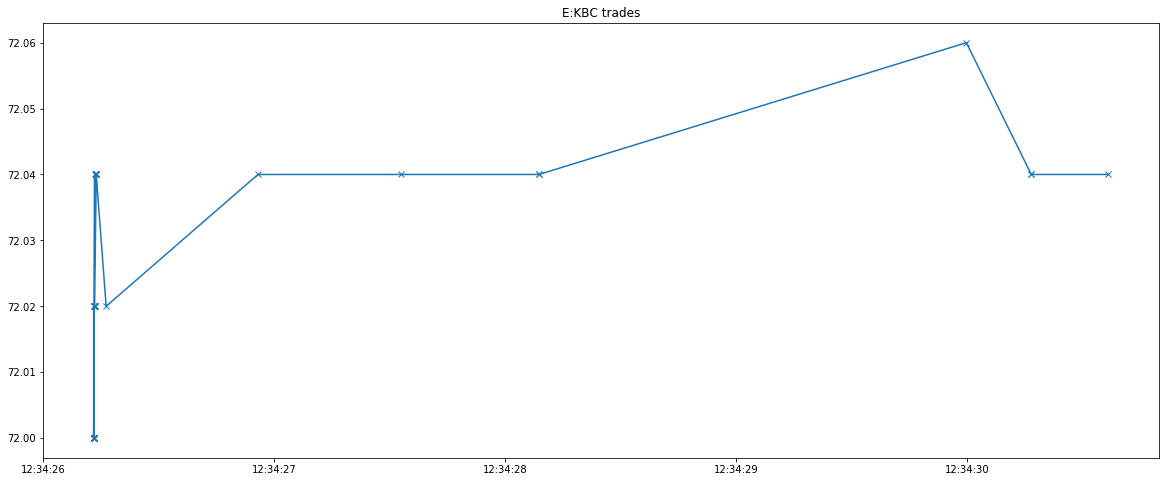

In [143]:
x = ask_per_symbol['trade_ts'].values
y = ask_per_symbol['trade_price'].values
y = y.astype(np.float)


plt.figure(figsize=(20,8))
plt.plot(x,y, '-x')
plt.title(sym + " trades");

In [ ]:
# 8 threads, 10 batch size
print(68450 / 9.126)
# 10 threads, 20 batch size
print(71700 / 7.867)
# 10 threads, 50 batch size
print(73800 / 6.825)
# 10 threads, 60 batch size
print(74040 / 6.810)
print(74560 / 8.209)
print(74559 / 7.673)
print(74070 / 6.182)
print(151140 / 12.715)
print(151140 / 13.485)